Programmer : Dennis Putra Hilmansyah
From: Sidoarjo, East Java, Indonesia
- 🙏 Donate 1 : https://saweria.co/devinnivis
- 🤘 Donate 2 : https://bagibagi.co/yeqiu_devinnivis

In [ ]:
# Clone YOLOv5 repository
#!git clone https://github.com/ultralytics/yolov5  
!git clone https://github.com/YeQiu29/YOLOV5-FACE-DETECTION.git # clone repo

# Change directory to yolov5
%cd yolov5

# Reset to a specific commitasa
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.11 MiB | 2.50 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
!nvidia-smi

Thu Feb 13 02:34:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   38C    P8              11W / 450W |   3516MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# install dependencies as necessary
!pip install requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Fatal error from pip prevented installation. Full pip output in file:
    /home/aibidik/.local/state/pipx/log/cmd_2025-02-13_02.35.37_pip_errors.log

Some possibly relevant errors from pip install:
    ERROR: Could not find a version that satisfies the requirement requirements-txt (from versions: none)
    ERROR: No matching distribution found for requirements-txt

Error installing requirements-txt.
Setup complete. Using torch 2.3.1+cu121 _CudaDeviceProperties(name='NVIDIA GeForce RTX 4090', major=8, minor=9, total_memory=24217MB, multi_processor_count=128)


If you use your own dataset, from RoboFlow, paste it below.

In [ ]:
'''
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CyXvrhPEZJdcVO9Gwj4T")
project = rf.workspace("dennisspace").project("data-latih-wajah-na5d0")
version = project.version(1)
dataset = version.download("yolov5")
'''

loading Roboflow workspace...
loading Roboflow project...


In [8]:
%cd Data-Latih-Wajah-1

/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5/Data-Latih-Wajah-1


In [9]:
%cat data.yaml

names:
- wajah
nc: 1
roboflow:
  license: CC BY 4.0
  project: data-latih-wajah-na5d0
  url: https://universe.roboflow.com/dennisspace/data-latih-wajah-na5d0/dataset/1
  version: 1
  workspace: dennisspace
test: ../test/images
train: Data-Latih-Wajah-1/train/images
val: Data-Latih-Wajah-1/valid/images


In [10]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
%cd ..

/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5


In [14]:
%cd models

/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5/models


In [15]:
%cat yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [16]:
%%writetemplate custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [17]:
%cd ..

/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5


In [18]:
!nvidia-smi

Thu Feb 13 02:40:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   40C    P8              11W / 450W |   3516MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
!pwd

/home/aibidik/Dev/jupyterlab/project/YoloV5_Wajah/yolov5


In [21]:
# train yolov5s on custom data for 200 epochs
# time its performance
%time
#%cd yolov5/
!python3 train.py --img 640 --batch 32 --epochs 200 --data 'Data-Latih-Wajah-1/data.yaml' --cfg 'models/custom_yolov5s.yaml' --weights '' --name yolov5s_results  --cache

CPU times: user 4 μs, sys: 4 μs, total: 8 μs
Wall time: 17.4 μs
/home/aibidik/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
train: weights=, cfg=models/custom_yolov5s.yaml, data=Data-Latih-Wajah-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, ent

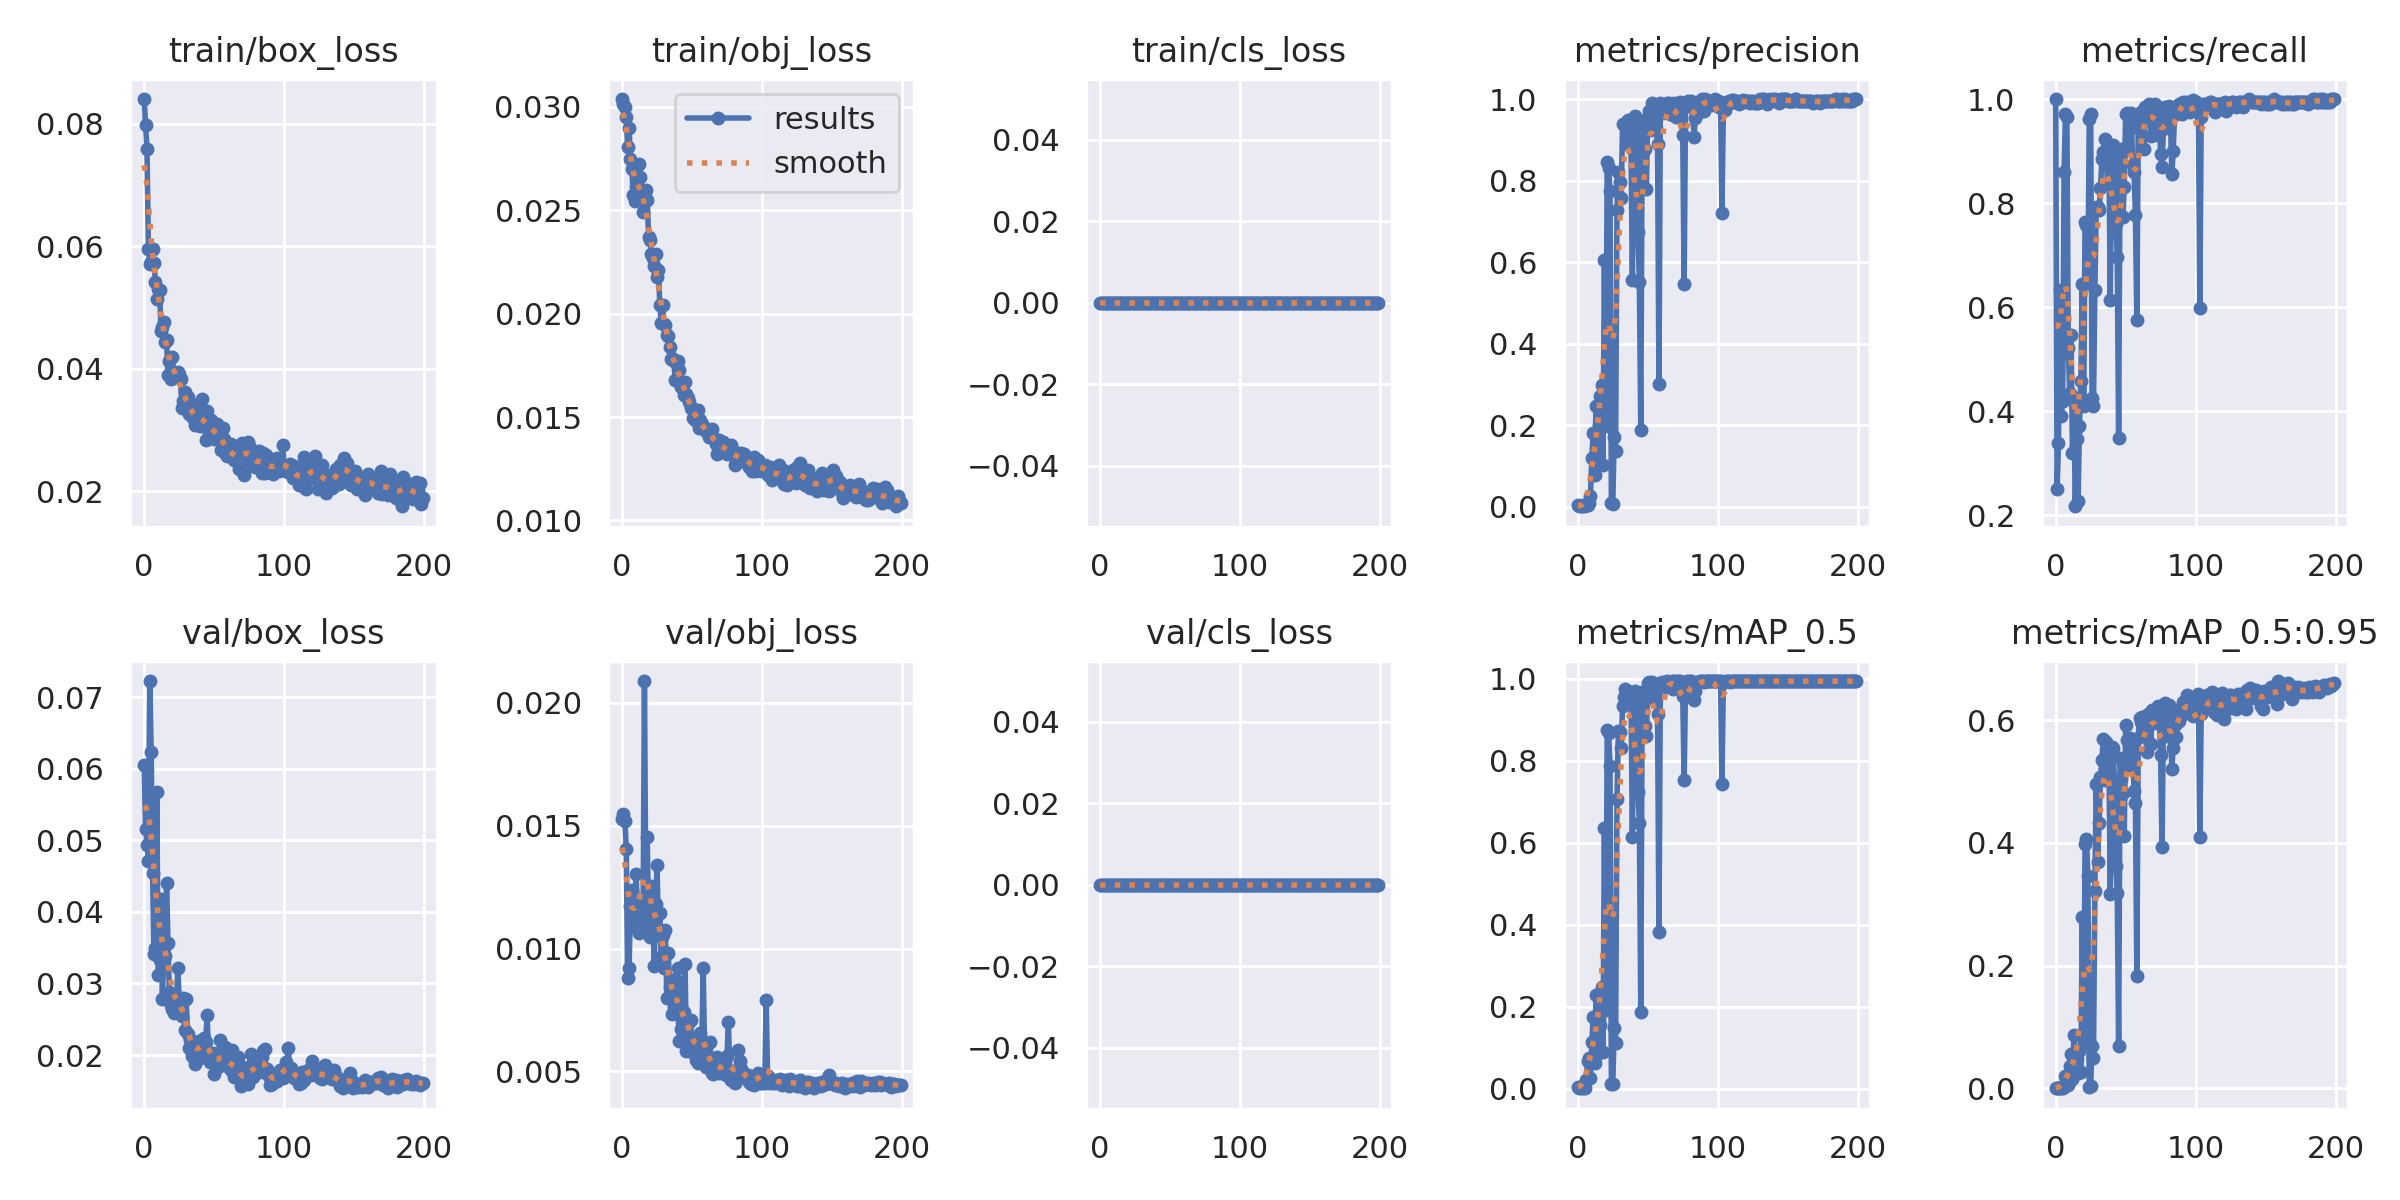

In [22]:
from PIL import Image
display(Image.open('runs/train/yolov5s_results2/results.png'))

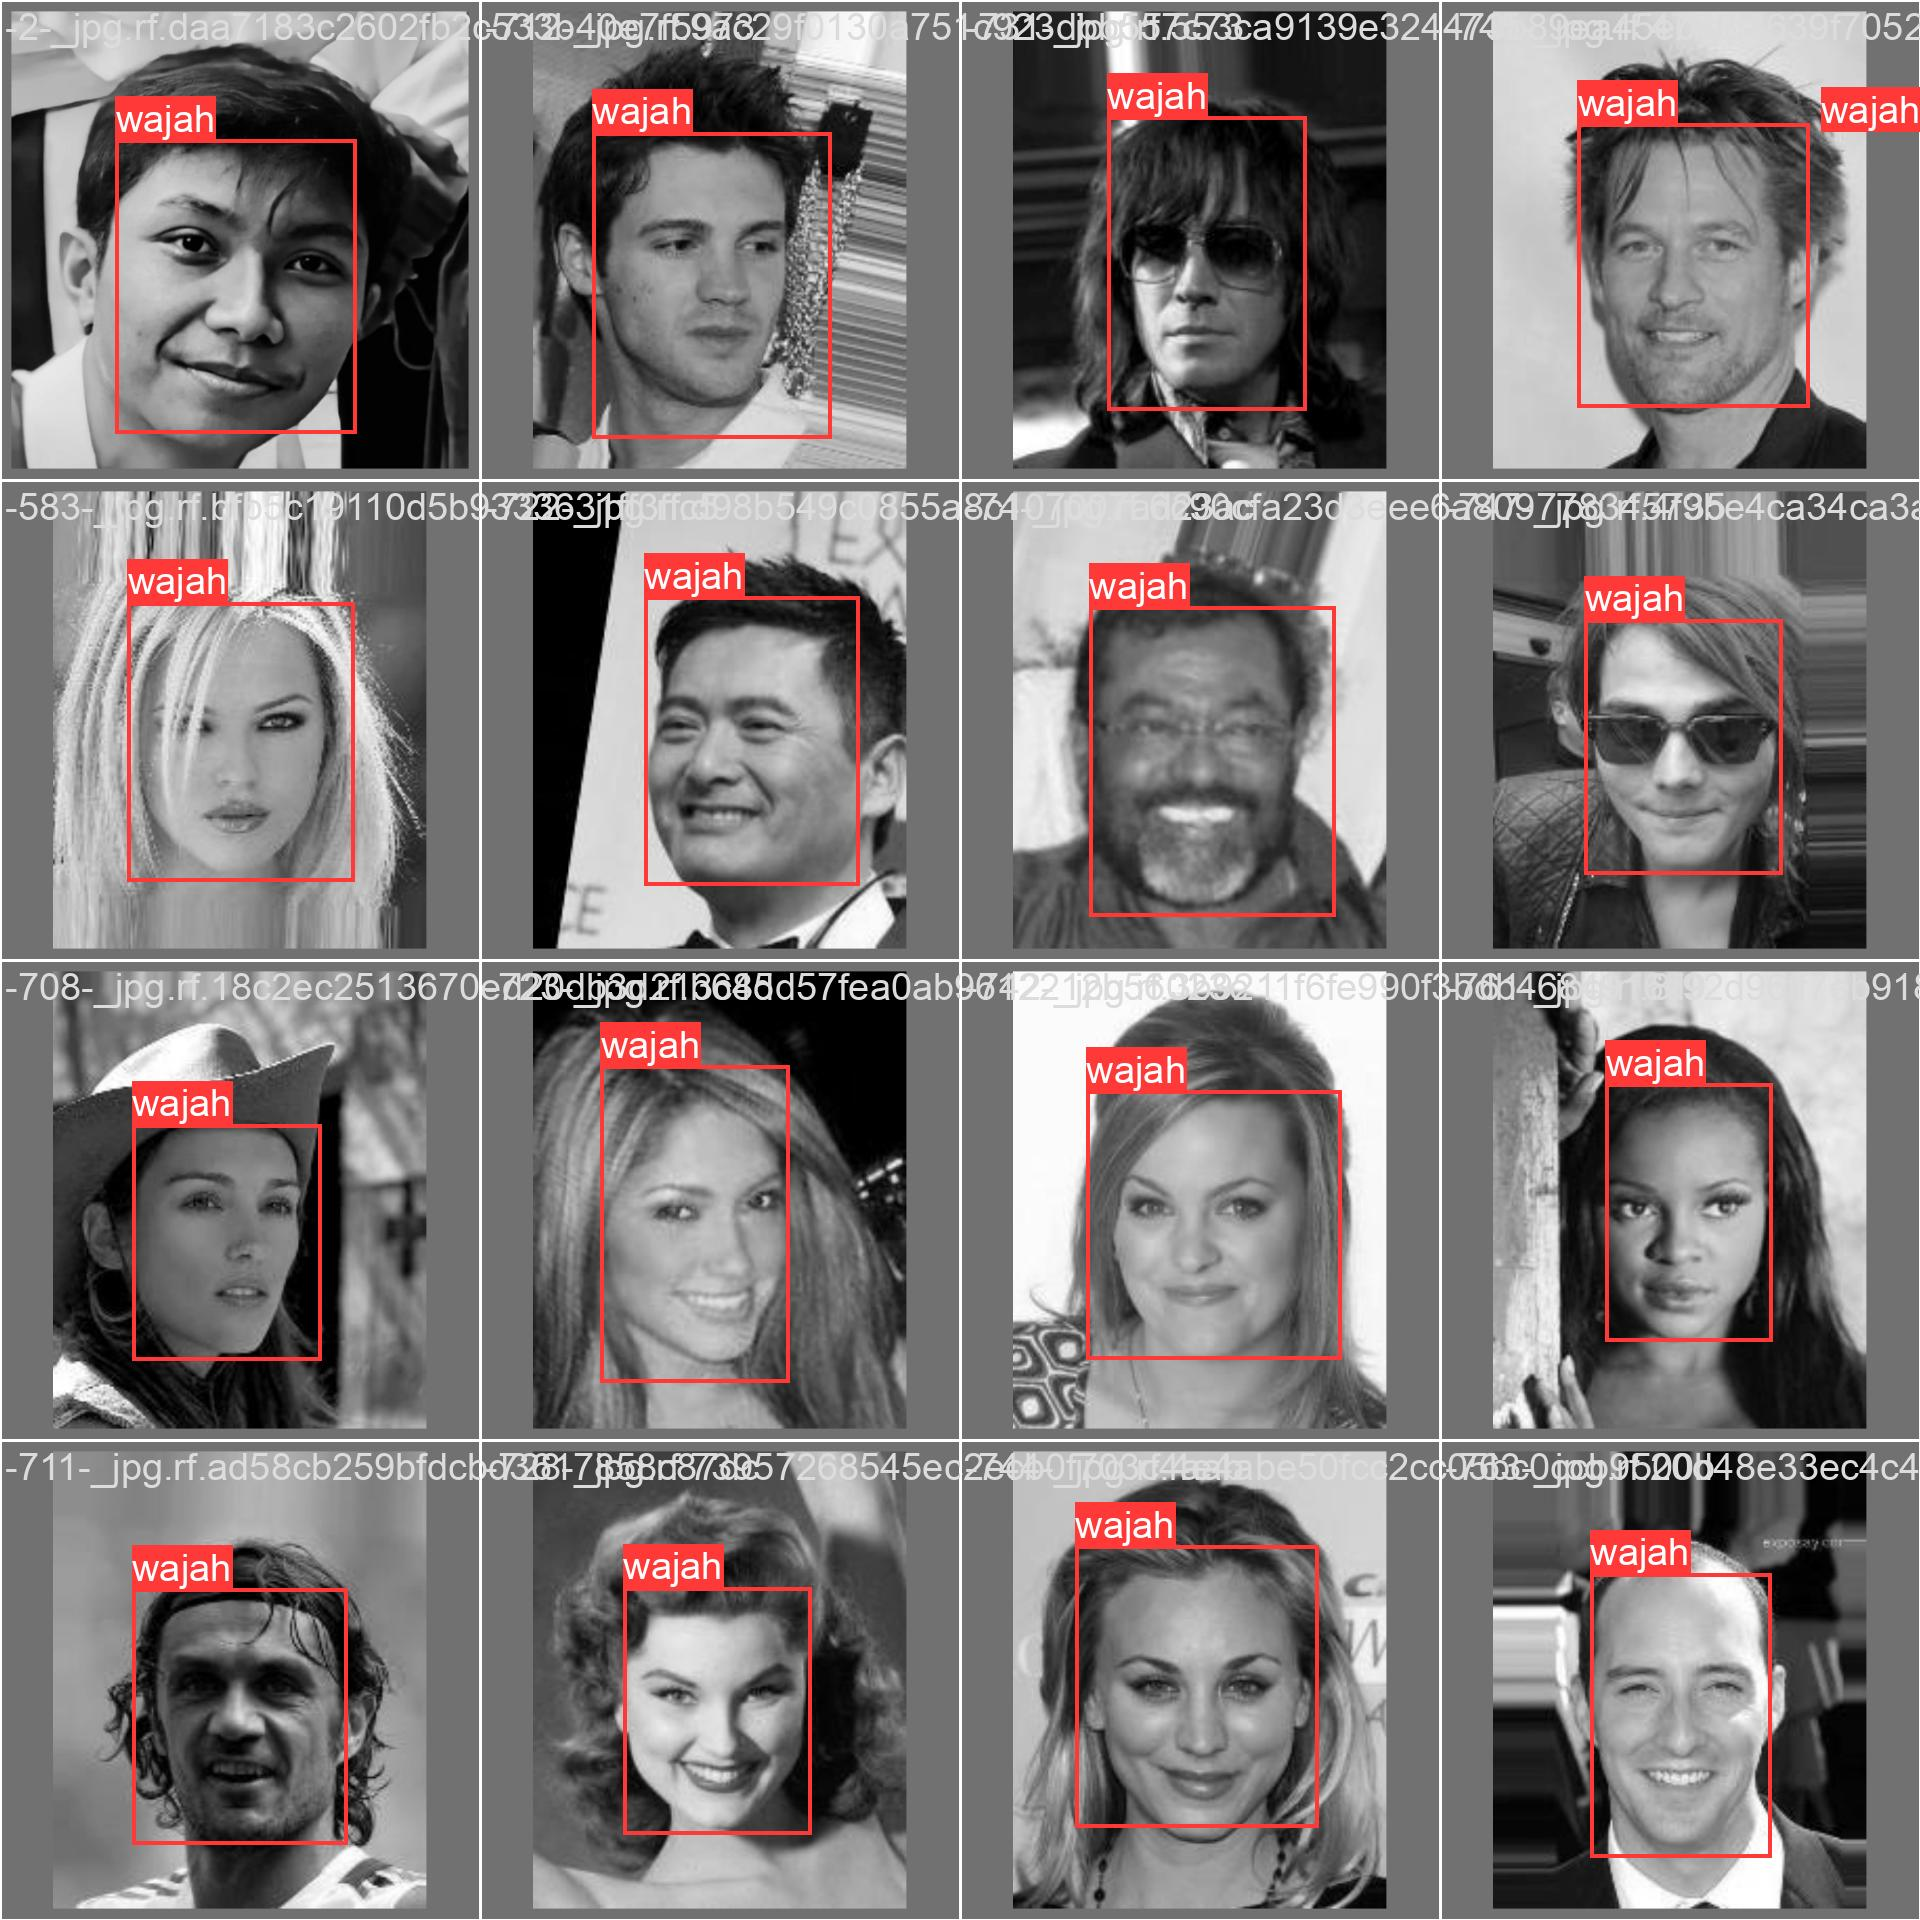

In [23]:
from PIL import Image
display(Image.open('runs/train/yolov5s_results2/val_batch0_labels.jpg'))

In [25]:
#%cd /content/yolov5/
!python3 detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 460 --conf 0.5 --source Data-Latih-Wajah-1/test/images/

/home/aibidik/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=Data-Latih-Wajah-1/test/images/, data=data/coco128.yaml, imgsz=[460, 460], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
cust

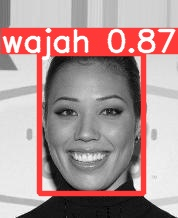

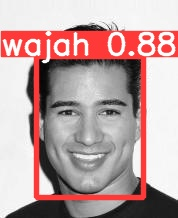

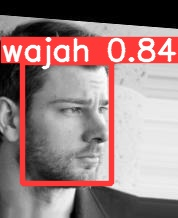

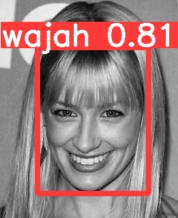

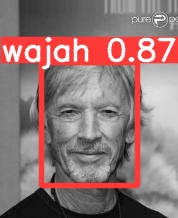

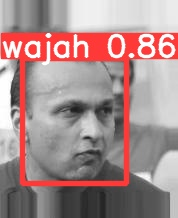

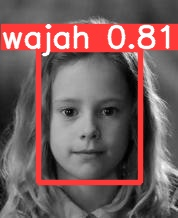

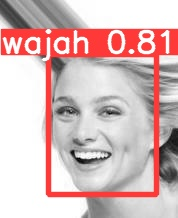

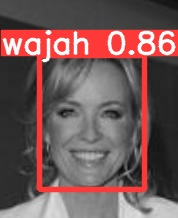

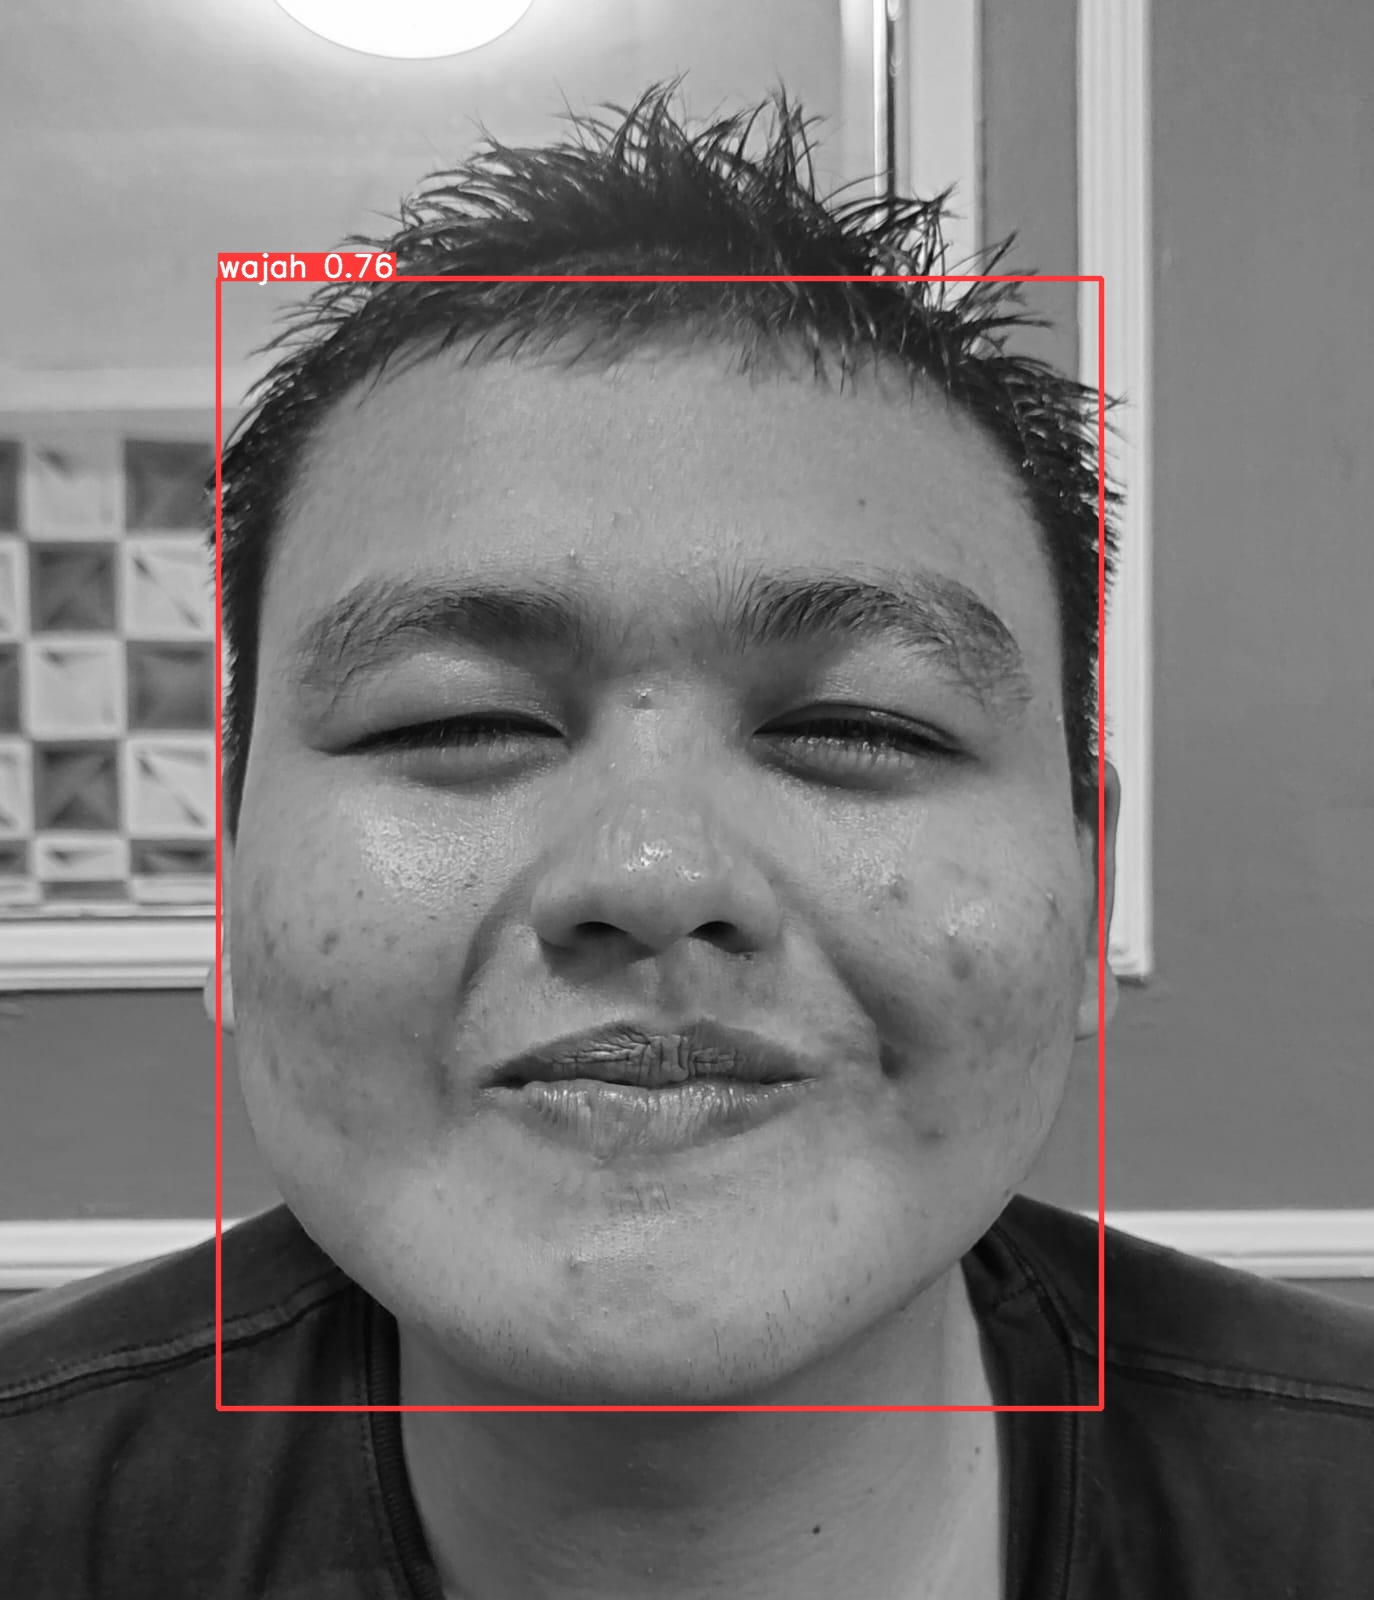

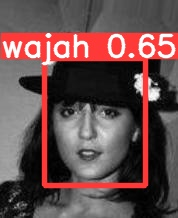

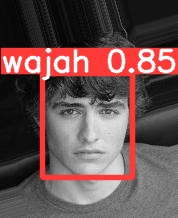

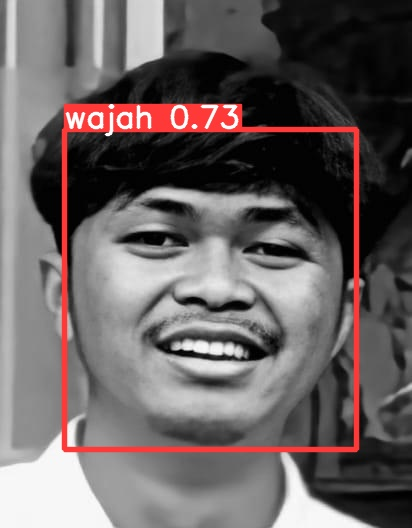

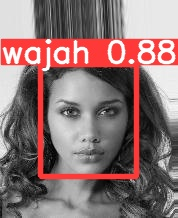

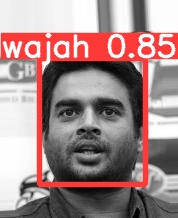

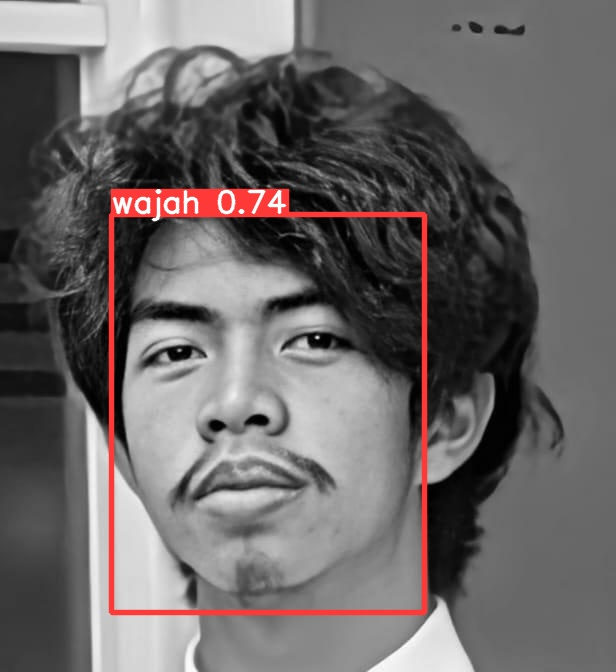

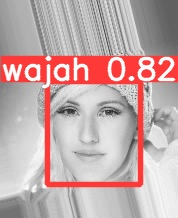

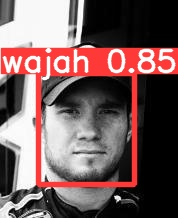

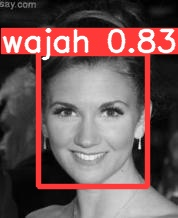

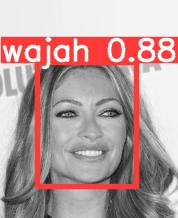

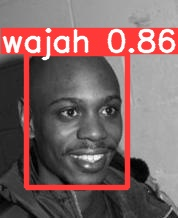

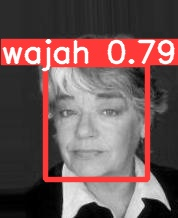

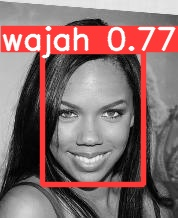

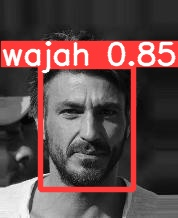

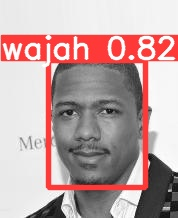

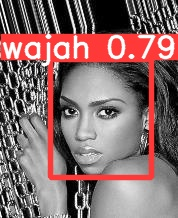

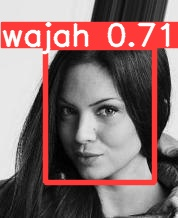

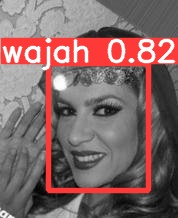

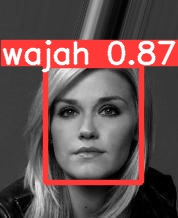

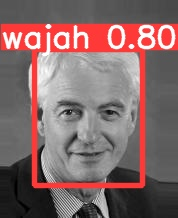

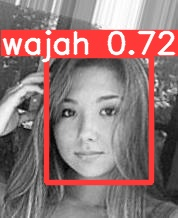

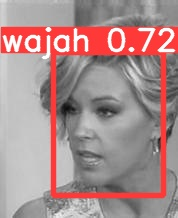

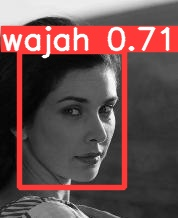

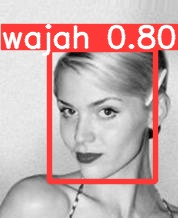

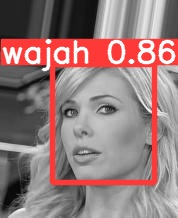

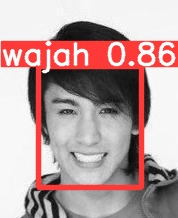

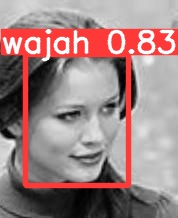

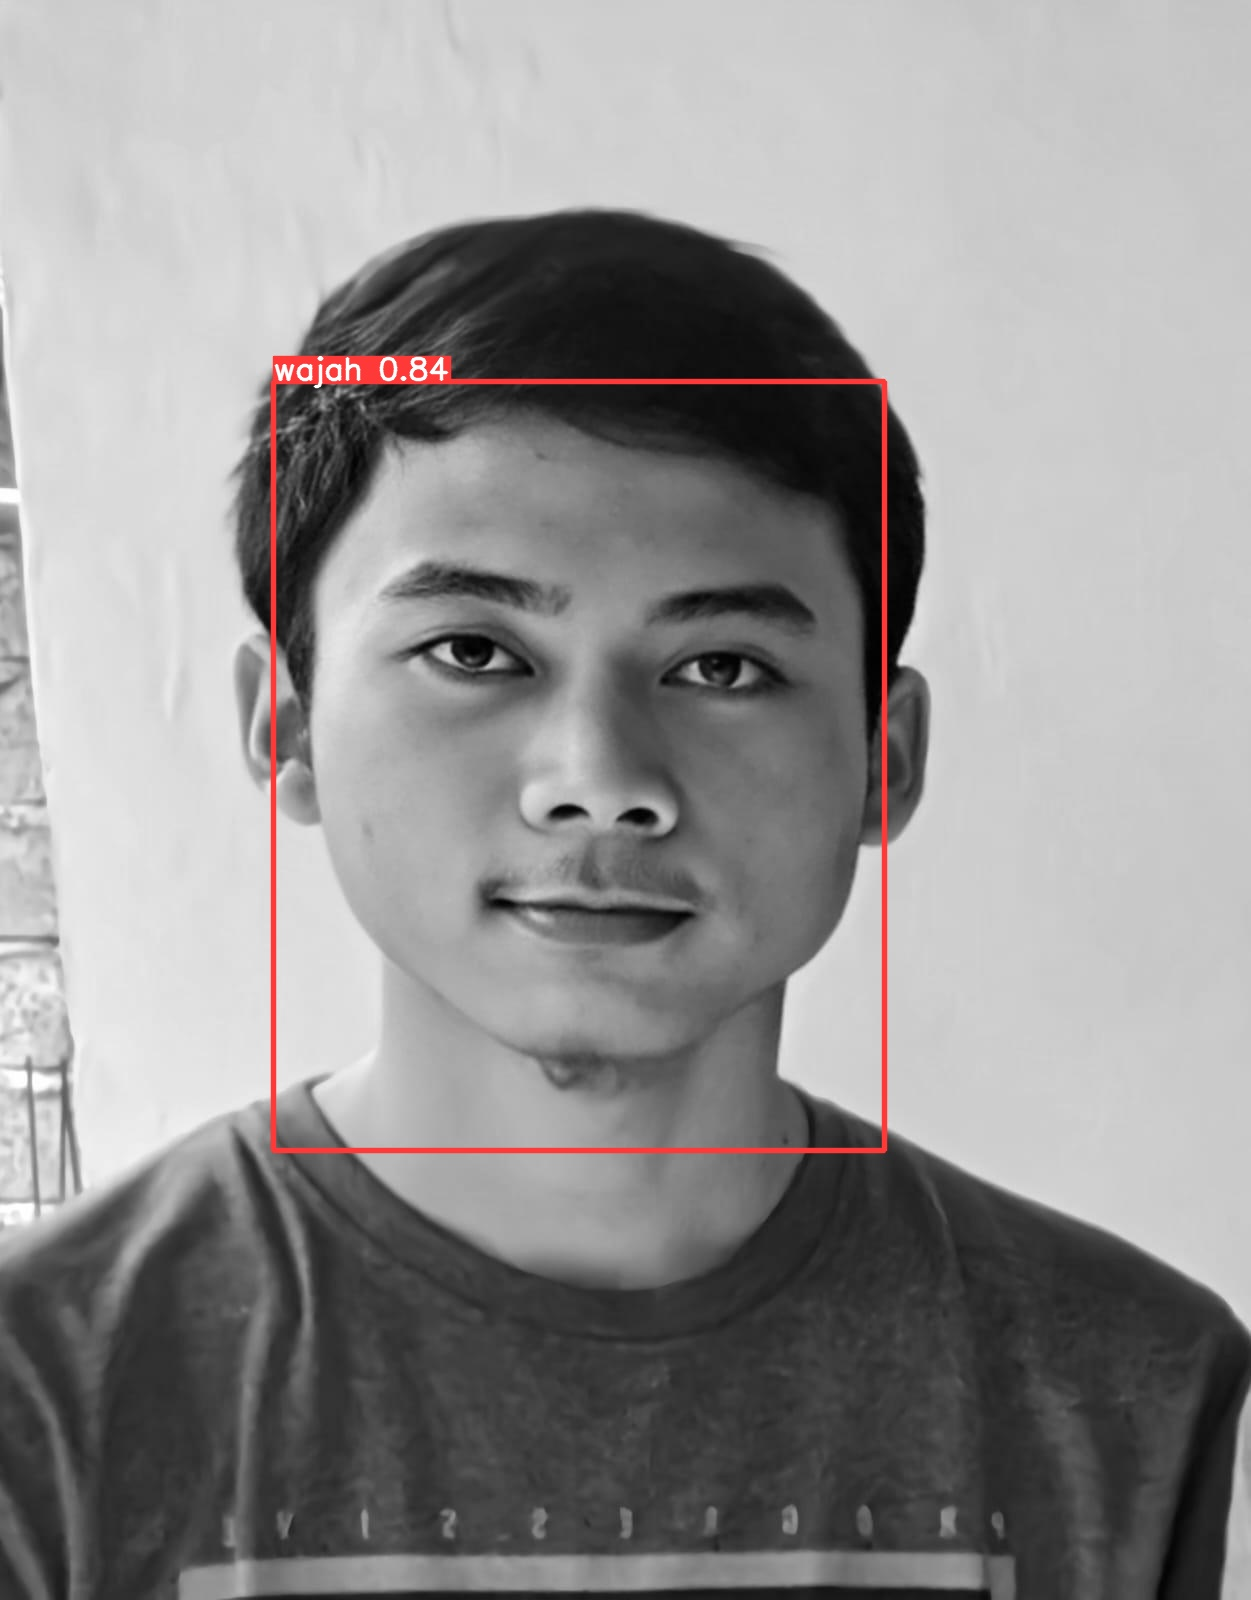

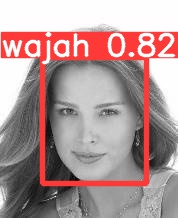

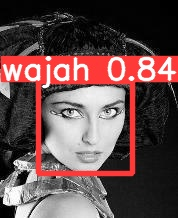

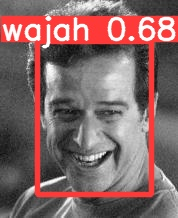

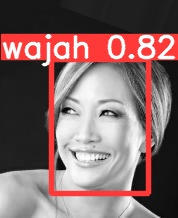

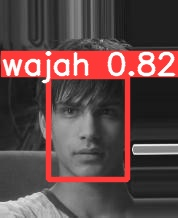

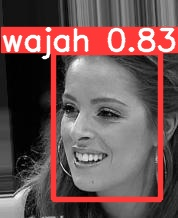

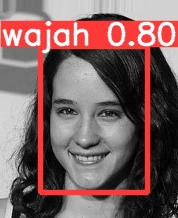

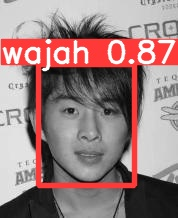

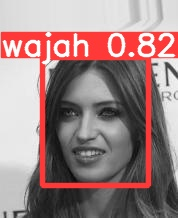

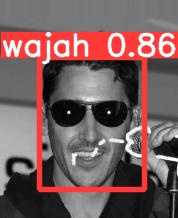

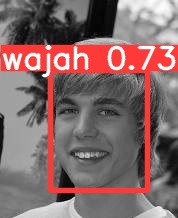

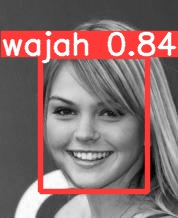

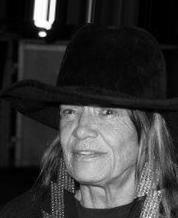

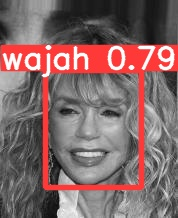

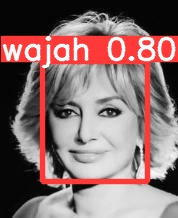

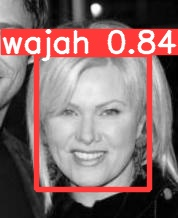

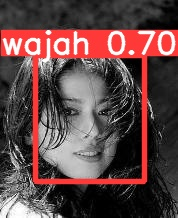

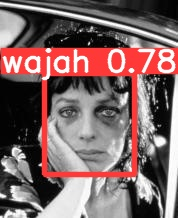

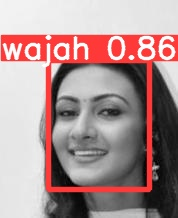

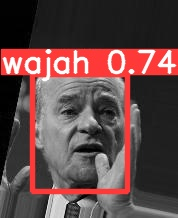

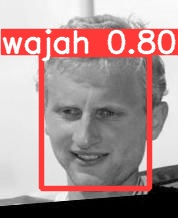

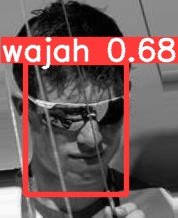

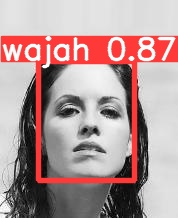

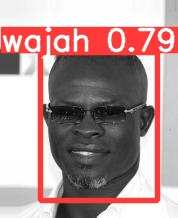

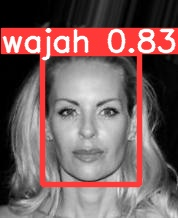

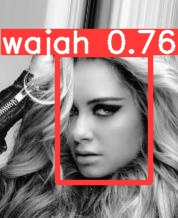

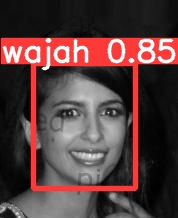

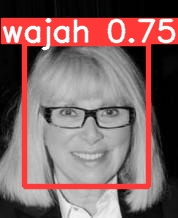

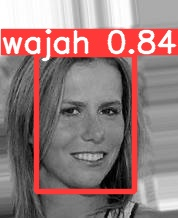

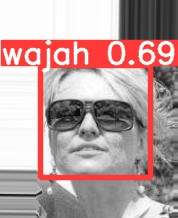

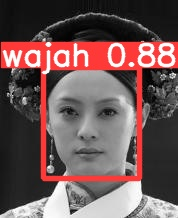

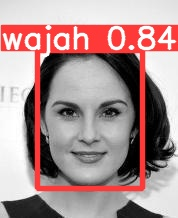

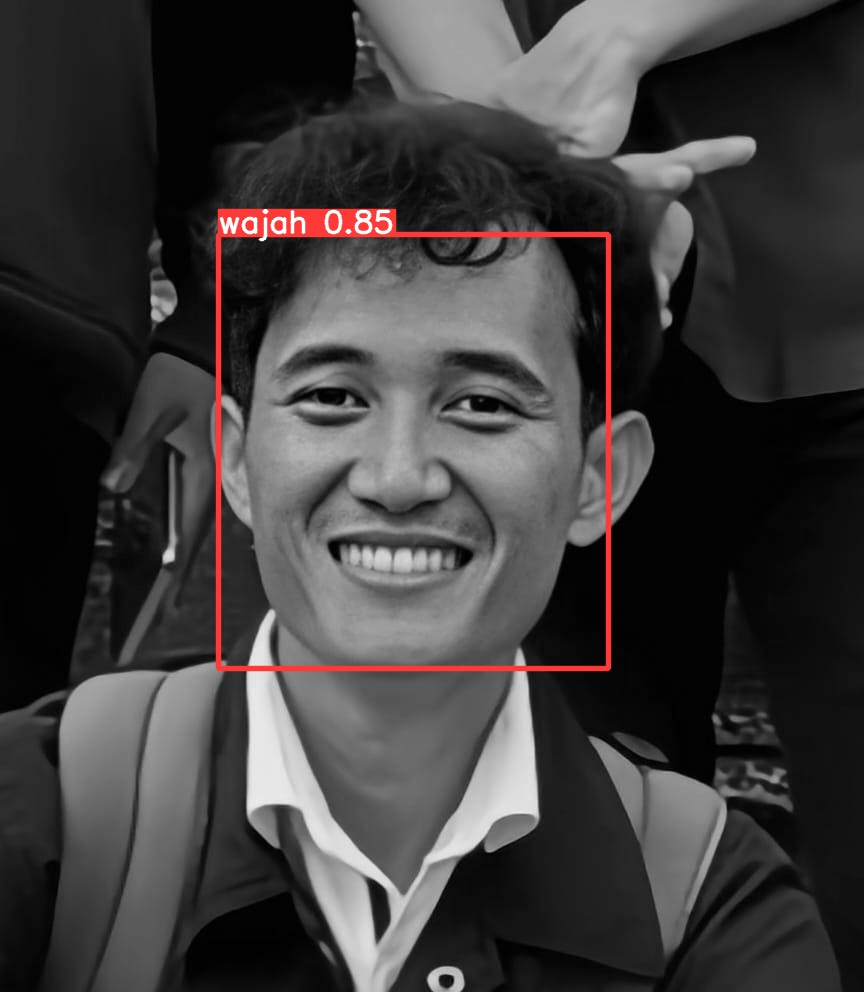

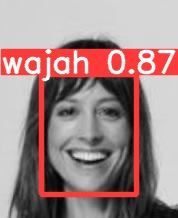

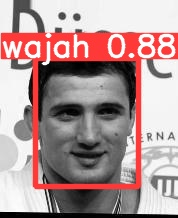

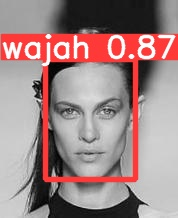

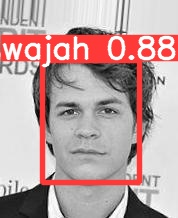

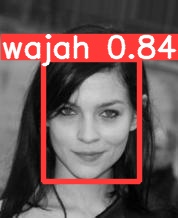

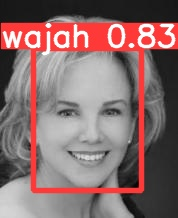

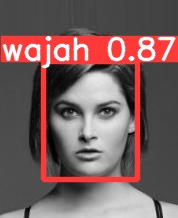

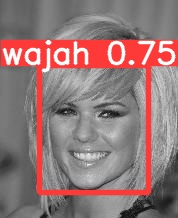

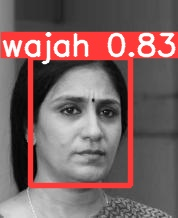

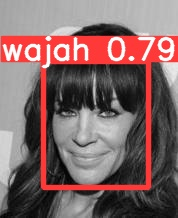

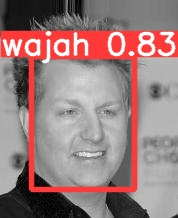

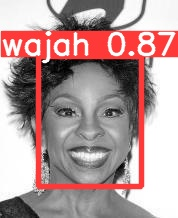

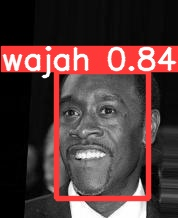

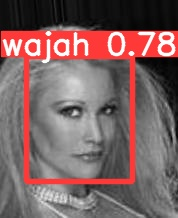

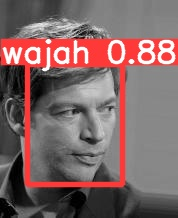

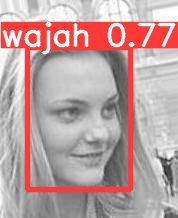

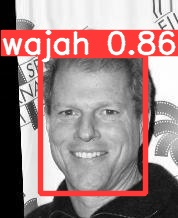

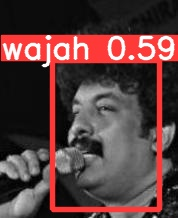

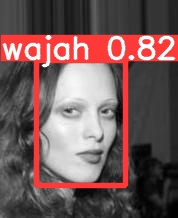

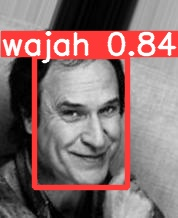

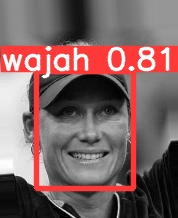

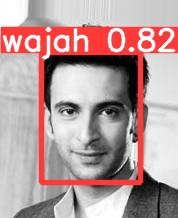

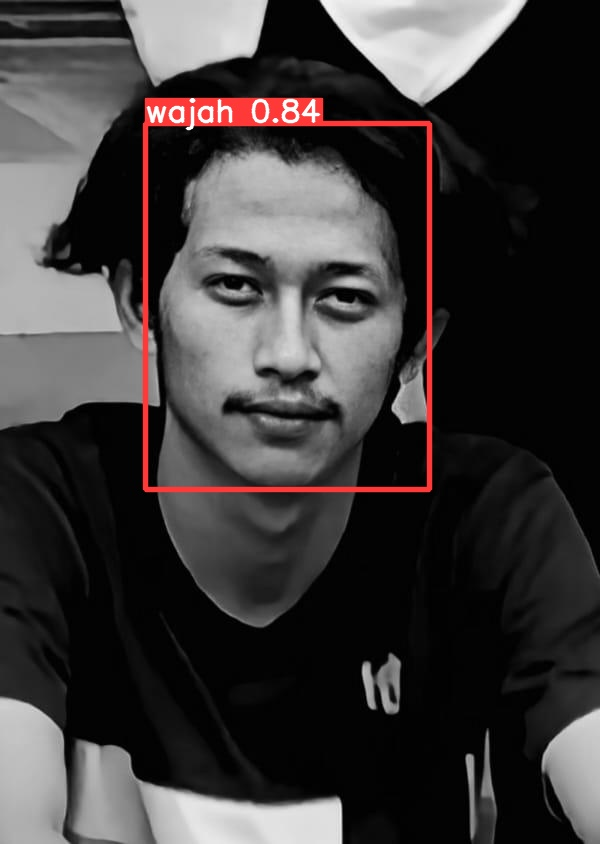

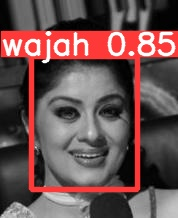

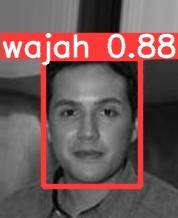

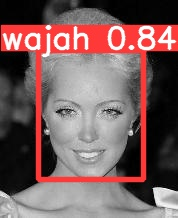

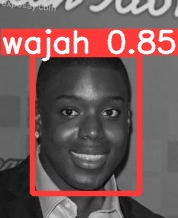

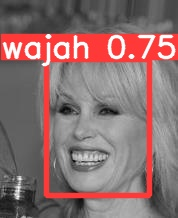

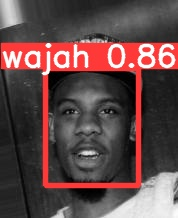

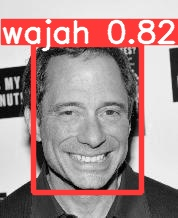

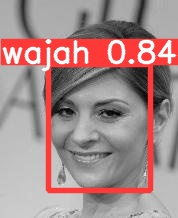

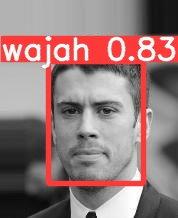

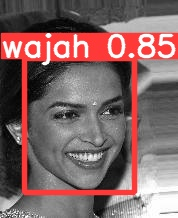

In [27]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('runs/detect/exp2/*.jpg')[:379]: #assuming JPG
    display(Image(filename=imageName))